<div style="text-align:center"><a href="https://colab.research.google.com/github/PexMor/jupyter-playground/blob/main/AspectRatio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<br/>
<a style="display:inline-block" href="https://github.com/PexMor/jupyter-playground/blob/main/AspectRatio.ipynb" target="_parent"><img alt="GitHub forks" src="https://img.shields.io/github/forks/PexMor/jupyter-playground?label=fork%20me&logo=github&style=plastic"></a></div>

# Aspect ratio

Purpose of this notebook is to show alternative solution for anonating function graphs with visually correct vectors while letting your graph be stretched as necessary.

The core of the processing is few functions that correct the visually misplaced vectors (arrows). This fix is visual augmentation that reflect the fact that the vectors has their size visually correct while drawn at off-scale from the function perspective.

In [1]:
!pip -q install -U watermark mpld3 numpy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import mpld3
import math

In [3]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
%load_ext watermark
%watermark -iv -i -z -u -m -w

Last updated: 2021-08-19T13:17:52.639392+02:00

Compiler    : Clang 12.0.5 (clang-1205.0.22.9)
OS          : Darwin
Release     : 20.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

mpld3     : 0.5.5
matplotlib: 3.4.2
numpy     : 1.21.2

Watermark: 2.2.0



In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Aspect ratio functions

This functions `get_ar`, `fixp` and `unfixp` maintain the grabbing actual aspect ratio as well as mapping from __visual__ coordinates into __"correct"__ coordinates by `unfixp` and then mapping back by `fixp`. Where `fixp` is short for __fix point__ with respect to stretch of __unit square__ due to actual __aspect ratio__.

Aspect ratio caching variable, when you first call the `get_ar`, then the aspect ratio is captured and any later change will not apply. So the future changes to the __ratio__ input values will not get trough. This might or might not be desired behavior.

In [5]:
# Initialize to None to indicate that we need to compute the value
g_ar = None

`get_ar` returns the current aspect ration

> NOTE: that if the aspect ratio is to be infered atomatically then you __have__ to plot the data prior to calling this function in particular you have to `plot` the function f(x) in concern. This sets the axes ranges for the plot. However this range might change to due to additional elements in the plot.

In [6]:
def get_ar():
    global g_ar, fix_ar
    if g_ar is None:
        (fig_w, fig_h) = plt.rcParams['figure.figsize']
        left, right = plt.xlim()
        bottom, top = plt.ylim()
        scale_x = fig_w / (right - left)
        scale_y = fig_h / (top - bottom)
        g_ar = scale_x / scale_y
        print(f"fix_ar = {fix_ar}, aspect ratio = {g_ar}")
    return g_ar

`fixp` - fix point position with respect to aspect ratio (modify `y` coordinate to maintain visual square-ness)

In [7]:
def fixp(p):
    ar = get_ar()
    return [p[0],p[1]*ar]

`unfixp` - reverse the operation of visualy correct position, this is needed when processing the vector or position in "correct" coordinates. After such processing the `fixp` is called again to project the new point back to visual.

In [8]:
def unfixp(p):
    ar = get_ar()
    return [p[0],p[1]/ar]

## Define some testing functions

Those functions and their first derivates will be used for testing the tangent and normal line at arbitrary point of the curve.

Those are:

* $f(x) = ln(x)$ - [Natural Log](https://en.wikipedia.org/wiki/Natural_logarithm), Logarithm with $e$ base
* $f(x) = x^2$
* $f(x) = e^x$
* $f(x) = sin( x/4 )$
* $f(x) = x^3+x^2$

In [9]:
# Helper class
class Vec(object):
    def __init__(self,x,y):
        self.x = x
        self.y = y

# Testing functions
x_fce_d = {}

x_fce_d["ln"] = {}
x_fce_d["ln"]["fce"] = lambda x: np.log(x+epsilon)
x_fce_d["ln"]["dfce"] = lambda x: 1/(x+epsilon)

x_fce_d["x2"] = {}
x_fce_d["x2"]["fce"] = lambda x: x**2
x_fce_d["x2"]["dfce"] = lambda x: 2*x

x_fce_d["sin"] = {}
x_fce_d["sin"]["fce"] = lambda x: np.sin(x/4)
x_fce_d["sin"]["dfce"] = lambda x: np.cos(x/4)/4

x_fce_d["e"] = {}
x_fce_d["e"]["fce"] = lambda x: np.exp(x)
x_fce_d["e"]["dfce"] = lambda x: np.exp(x)

x_fce_d["x3"] = {}
x_fce_d["x3"]["fce"] = lambda x: x**3+x**2
x_fce_d["x3"]["dfce"] = lambda x: 3*x**2+2*x

In [10]:
def f(x):
    global fsel, x_fce_d
    return x_fce_d[fsel]["fce"](x)

def slope(x): 
    global fsel, x_fce_d
    return x_fce_d[fsel]["dfce"](x)

def line(x, x1, y1):
    return slope(x1)*(x - x1) + y1

def two_points(x,y):
    delta_y = np.arctan( slope(x) ) / scale_norm
    delta_x = - np.arctan( slope(x) ) / scale_norm
    p_start = [ x - delta_x, x + delta_x ]
    p_end = [ y - delta_y, y + delta_y ]
    return [p_start,p_end]

def perpendicular( a ) :
    b = np.empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b

def normalize(a):
    a = np.array(a)
    return a/np.linalg.norm(a)

def vec_at(x,y):
    global fix_ar
    tan = ( 1, slope(x))
    tan_norm = normalize(tan)
    # fix with respect to aspect ratio
    if fix_ar:
        tan_norm = fixp(normalize(unfixp(tan)))
    norm = perpendicular(tan_norm)
    # fix with respect to aspect ratio
    if fix_ar:
        norm = fixp(perpendicular(unfixp(tan_norm)))
    n_tan = Vec( tan_norm[0], tan_norm[1])
    n_norm = Vec( norm[0], norm[1] )
    return (n_tan,n_norm)

def norm_ortho(v):
    v_norm = normalize(v)
    norm = perpendicular(v_norm)
    return norm

In [11]:
no_tan = 10
x_start = 0.1
x_end = 20.0 + x_start
no_points = 100
epsilon = 0.0
scale_norm = 10
scale_tan = 0.5
# select the function to display
fsel = "ln"
# do the correction for anotations
fix_ar = True

In [12]:
# Create table with values
x = np.linspace(x_start, x_end, no_points)
y = f(x)

## The demo function

`fix_demo` a function to display a graph of selected function (`fsel` value)

In [13]:
def fix_demo(fig_w,fig_h,a_fix_ar=True,a_fsel="ln",set_aspect=False):
    global fsel, g_ar, fix_ar
    fsel = a_fsel
    fix_ar = a_fix_ar
    plt.rcParams['figure.figsize']=[fig_w,fig_h]
    fig, ax = plt.subplots()
    if set_aspect:
        ax.set_aspect('equal')
    plt.grid(color='gray', linestyle='dotted', linewidth=1)
    plt.plot(x,f(x))
    g_ar = None
    get_ar()
    for xx in range(no_tan):
        x1 = 1.0 * xx * (x_end - x_start) / no_tan + x_start
        y1 = f(x1)
        (n_tan,n_norm) = vec_at(x1,y1)
        arrow = mpatches.FancyArrowPatch((x1,y1),(x1+n_tan.x,y1+n_tan.y), mutation_scale=10,color=f"C{xx+2}")
        ax.add_patch(arrow)
        arrow = mpatches.FancyArrowPatch((x1,y1),(x1+n_norm.x,y1+n_norm.y), mutation_scale=10,color=f"C{xx+2}")
        ax.add_patch(arrow)
        plt.scatter(x1, y1, marker="o", s=1500, facecolors='none', edgecolors=f"C{xx+2}")
        plt.scatter(x1, y1, marker="o", s=20, color=f"C{xx+2}")
    plt.show()

## The demo

The default behavior of the `matplotlib` without any tweaks the size of __tangent__ and __normal__ vectors looks uneven.

fix_ar = False, aspect ratio = 0.5303304908059076


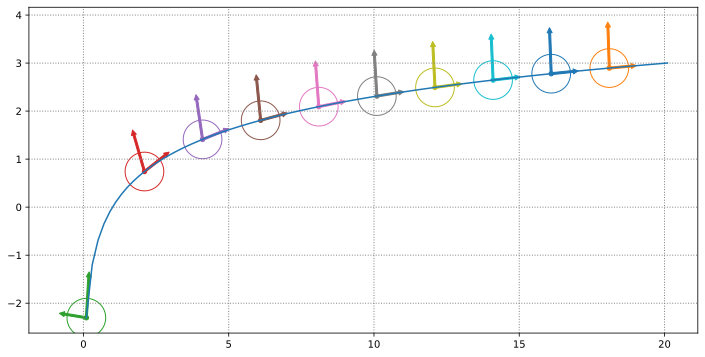

In [14]:
fix_demo(12,6,a_fix_ar=False,a_fsel="ln",set_aspect=False)

The alternative to the `fixp` and `unfixp` is to set __aspect__ ratio explicitly, which has a negative side effect of `ignoring` the preset image size `plt.rcParams['figure.figsize']`.

fix_ar = False, aspect ratio = 0.5303304908059076


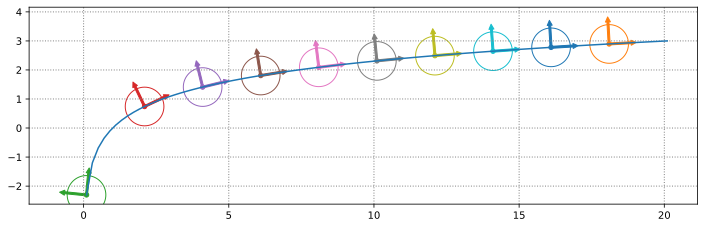

In [15]:
fix_demo(12,6,a_fix_ar=False,a_fsel="ln",set_aspect=True)

Alternative is to use default values/bahavior which does fixing sizes of the vectors.

fix_ar = True, aspect ratio = 0.5303304908059076


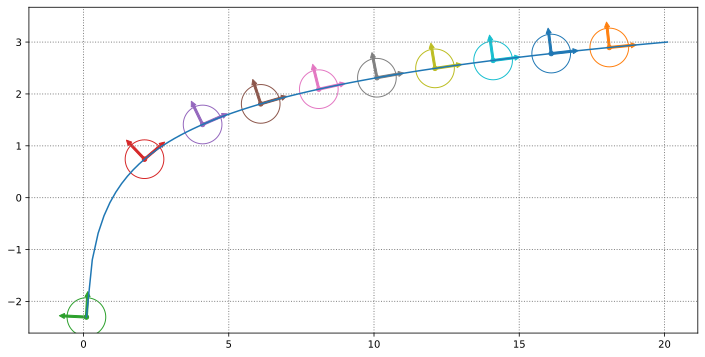

In [16]:
fix_demo(12,6)
# equivalent to:
# fix_demo(12,6,a_fix_ar=True,a_fsel="ln",set_aspect=False)

Works well any target image size.

fix_ar = True, aspect ratio = 0.2651652454029538


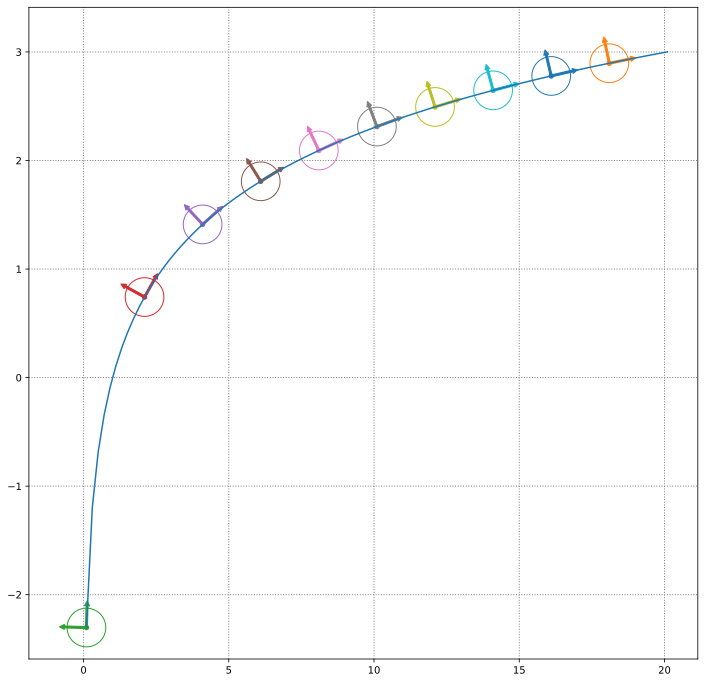

In [17]:
fix_demo(12,12)

## The aspect experiments

Below you can find the illustration of resizing the canvas.

In [18]:
def rplot(ax,a,d,color="C1"):
    ax.plot([a[0],a[0]+d[0]],[a[1],a[1]+d[1]],color=color)

def do_plot(a_arr,d_arr):
    global g_ratio, g_ar
    fig, ax = plt.subplots()
    plt.grid(color='r', linestyle='dotted', linewidth=1)
    ax.set_xlim(-20, 20)
    ax.set_ylim(-20, 20)
    g_ar = None
    for ii in range(len(a_arr)):
        a = a_arr[ii]
        d = d_arr[ii]
        rplot(ax,a,d,color=f"C{ii+2}")
        n = fixp(normalize(unfixp(d)))
        o = fixp(norm_ortho(unfixp(d)))
        rplot(ax,a,n)
        rplot(ax,a,o)
        ax.scatter(a[0],a[1],s=1000, facecolors='none', edgecolors=f"C{ii+2}", linewidth=1, linestyle='dotted')
    plt.show()

Prepare the array of points and test vectors at those point.

In [19]:
a_arr = [[-10,-10],[-10,10],[10,10],[10,-10]]
d_arr = [[5,5],[3,7],[-7,3],[3,-7]]

Draw the image with square canvas. Which is expected to work regardless of vector tweaks, actually when the aspect ratio is equal to `1` then you do not have to worry.

fix_ar = True, aspect ratio = 1.0


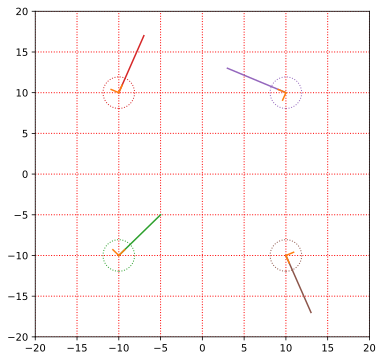

In [20]:
plt.rcParams['figure.figsize']=[6,6]
do_plot(a_arr,d_arr)

This is an extreme squeeze on `y` axis `10:3`, where the correction of normal and tangent gets in action.

fix_ar = True, aspect ratio = 3.3333333333333335


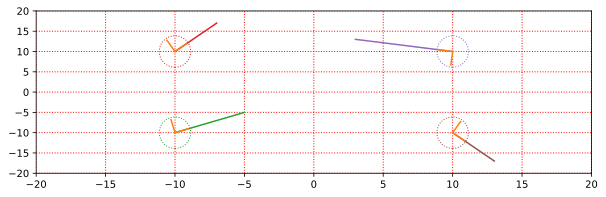

In [21]:
plt.rcParams['figure.figsize']=[10,3]
do_plot(a_arr,d_arr)

A squeeze in the other direction `x` axis ratio `10:15`

fix_ar = True, aspect ratio = 0.6666666666666666


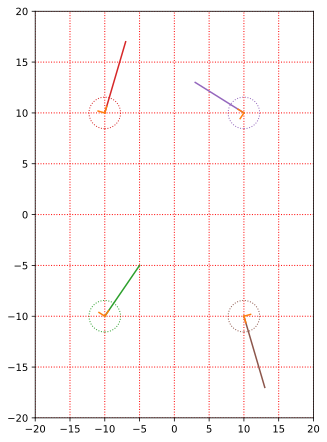

In [22]:
plt.rcParams['figure.figsize']=[5,7.5]
do_plot(a_arr,d_arr)

Image showing the point shift to accomodate to the aspect ratio.

The Orange points are at their fixed (though incorrect) position while the blue points are at the correct position (though visually unexpected).

fix_ar = True, aspect ratio = 1.25


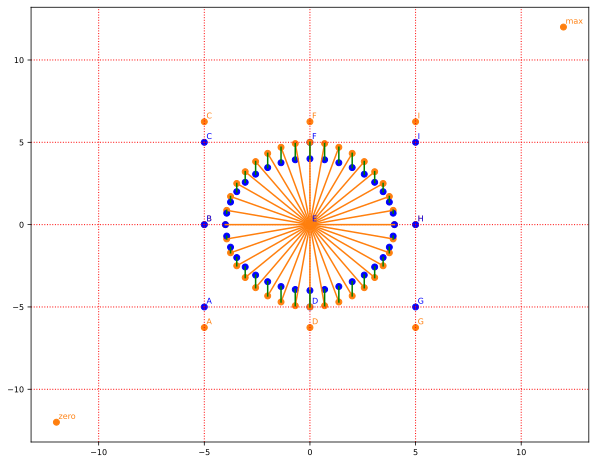

In [23]:
%config InlineBackend.figure_formats = ['svg']
plt.rcParams['figure.figsize']=[10,8]
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
# plt.tick_params(labelsize=8)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title
def lplot(ax,pax,pbx,color="C1"):
    a = fixp(pax)
    b = fixp(pbx)
    ax.plot([a[0],b[0]],[a[1],b[1]],color=color)

def adj_plot(ax,p,color="C1"):
    a = fixp(p)
    b = p
    ax.plot([a[0],b[0]],[a[1],b[1]],color=color)
    
def pplot(ax,px,name,color="C1",prop={'ha': 'left', 'va': 'bottom'},hide_point=False,hide_text=False):
    p = fixp(px)
    if not hide_point:
        ax.scatter(p[0],p[1],marker="o",color=color)
    teps = 0.1
    if not hide_text:
        ax.text(p[0]+teps,p[1]+teps,name,prop,color=color)

def tpplot(ax,p,name,color="C1",prop={'ha': 'left', 'va': 'bottom'},hide_point=False,hide_text=False):
    if not hide_point:
        ax.scatter(p[0],p[1],marker="o",color=color)
    teps = 0.1
    if not hide_text:
        ax.text(p[0]+teps,p[1]+teps,name,prop,color=color)

def fake_plot():
    global g_ar
    g_ar = None
    fig, ax = plt.subplots()
    plt.grid(color='r', linestyle='dotted', linewidth=1)
    pts = []
    npts = {}
    sp=12
    tpplot(ax,[-sp,-sp],"zero")
    tpplot(ax,[sp,sp],"max")
    for xx in range(3):
        for yy in range(3):
            pt=[xx*5.0-5.0,yy*5.0-5.0]
            name = chr(65+xx*3+yy)
            pplot(ax,pt,name)
            tpplot(ax,pt,name,color='b')
            npts[name] = pt
            pt.append(pt)
    dia = 4.0
    no_ang = 36
    for ang in range(no_ang):
        angle = 360.0 * ang / no_ang
        rad = angle * math.pi / 180
        xx = dia * math.cos(rad)
        yy = dia * math.sin(rad)
        lplot(ax,npts['E'],[xx,yy])
        adj_plot(ax,[xx,yy],color="green")
        pplot(ax,[xx,yy],f"{angle:.1f}",prop={'ha': 'center', 'va': 'center'},hide_text=True,color='C1')
        tpplot(ax,[xx,yy],f"{angle:.1f}",prop={'ha': 'center', 'va': 'center'},hide_text=True,color='b')
fake_plot()